In [6]:
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [7]:
jsons = {}
complaint_glob = "/scr/ig_pipeline/cad/*/*/complaints.json"
for fn in glob.glob(complaint_glob):
    fn = pathlib.Path(fn)
    with open(fn, "r") as f:
        jsons["/".join(fn.parts[-3:-1])] = json.load(f)

In [8]:
print(jsons.keys())

dict_keys(['scenes/Beechwood_1_int', 'scenes/office_cubicles_left', 'scenes/Wainscott_1_int', 'scenes/Benevolence_0_int', 'scenes/Rs_garden', 'scenes/hall_train_station', 'scenes/office_large', 'scenes/hotel_suite_large', 'scenes/grocery_store_half_stocked', 'scenes/Ihlen_0_int', 'scenes/commercial_kitchen_fire_extinguisher', 'scenes/Pomaria_0_garden', 'scenes/house_double_floor_upper', 'scenes/restaurant_hotel', 'scenes/public_restroom_white', 'scenes/school_gym', 'scenes/grocery_store_convenience', 'scenes/Merom_0_int', 'scenes/Pomaria_0_int', 'scenes/public_restroom_brown', 'scenes/public_restroom_marble', 'scenes/restaurant_brunch', 'scenes/school_computer_lab_and_infirmary', 'scenes/Pomaria_2_int', 'scenes/restaurant_cafeteria', 'scenes/public_restroom_blue', 'scenes/office_vendor_machine', 'scenes/grocery_store_asian', 'scenes/Rs_int', 'scenes/house_double_floor_lower', 'scenes/Pomaria_1_int', 'scenes/office_cubicles_right', 'scenes/Beechwood_0_int', 'scenes/Benevolence_1_int', '

In [9]:
next(iter(jsons.values()))

[{'object': 'ceilings-ytbprd',
  'complaint': 'ceiling',
  'processed': True,
  'type': 'collision',
  'additional_info': 'Was at least one of the collision mesh candidates acceptable?'}]

In [17]:
import collections
import re

complaints_by_type = collections.defaultdict(list)
complained_objects_by_type = collections.defaultdict(set)
complaint_types_by_object = collections.defaultdict(set)

for j in jsons.values():
    for complaint in j:
        if complaint["processed"]:
            continue
            
        complaint_type = complaint["type"]
        complaints_by_type[complaint_type].append(complaint)
        obj_id = complaint["object"].split("-")[-1]
        complained_objects_by_type[complaint_type].add(obj_id)
        complaint_types_by_object[obj_id].add(complaint_type)


In [11]:
print(complaints_by_type.keys())

dict_keys(['collision', 'centerofmass', 'appearance', 'unknown', 'metalink', 'connectedness', 'structurethickness', 'handle', 'category', 'clothappearance', 'joint', 'structureconnectedness', 'structureunclosed', 'softbody', 'scale', 'substanceness'])


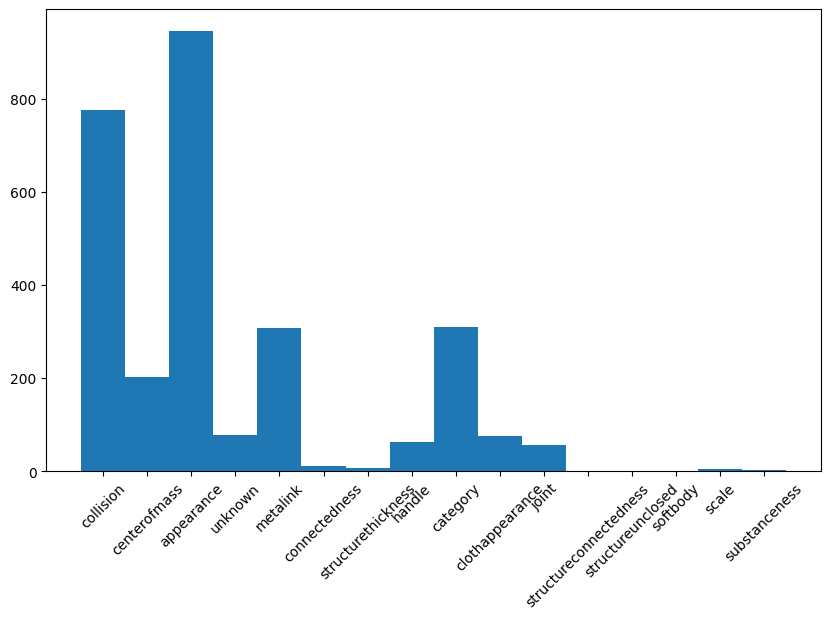

In [12]:
plt.rcParams["figure.figsize"] = (10,6)
labels, values = zip(*[(k, len(v)) for k, v in complaints_by_type.items()])

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation=45)
plt.show()

In [14]:
appearance_complaint_objects = complained_objects_by_type["appearance"]

In [15]:
# Load the bad material objects
with open("bad_materials.json", "r") as f:
    bad_materials = set(json.load(f))

print("Objects that are complained about for appearance:", len(appearance_complaint_objects))
print("Objects that have non-Vray materials:", len(bad_materials))
print("Objects that are complained about for appearance and have non-Vray materials:", len(appearance_complaint_objects & bad_materials))
print("Objects that have non-Vray material but not complained about for appearance:", len(bad_materials - appearance_complaint_objects))
print("Objects that are complained about for appearance but have good materials:", len(appearance_complaint_objects - bad_materials))

Objects that are complained about for appearance: 833
Objects that have non-Vray materials: 1394
Objects that are complained about for appearance and have non-Vray materials: 291
Objects that have non-Vray material but not complained about for appearance: 1103
Objects that are complained about for appearance but have good materials: 542


In [20]:
providers = json.loads(pathlib.Path("/scr/ig_pipeline/artifacts/pipeline/object_inventory.json").read_text())["providers"]
objects_by_provider = collections.defaultdict(set)
for obj, provider in providers.items():
    objects_by_provider[provider].add(obj.split("-")[-1])

provider_stats = {}
for provider, objects in objects_by_provider.items():
    provider_complained_objects = objects & set(complained_objects_by_type.keys())
    provider_uncomplained_objects = objects - provider_complained_objects
    provider_appearance_complaint_objects = objects & complained_objects_by_type["appearance"]
    provider_collision_complaint_objects = objects & (complained_objects_by_type["collision"] | complained_objects_by_type["handle"])
    provider_other_complaint_objects = provider_complained_objects - provider_appearance_complaint_objects - provider_collision_complaint_objects

    # We want to make sure that uncomplained + appearance + collision + other = total. To do this, we want to create a "multiple" complaint
    # category, and remove the multiple-complaint objects from each of the separate lists.
    # This is a bit of a hack, but it works.
    complaint_count_per_object = collections.Counter()
    complaint_count_per_object.update(provider_appearance_complaint_objects)
    complaint_count_per_object.update(provider_collision_complaint_objects)
    complaint_count_per_object.update(provider_other_complaint_objects)
    provider_multiple_complaint_objects = set(
        obj for obj, count in complaint_count_per_object.items() if count > 1
    )
    provider_appearance_complaint_objects -= provider_multiple_complaint_objects
    provider_collision_complaint_objects -= provider_multiple_complaint_objects
    provider_other_complaint_objects -= provider_multiple_complaint_objects

    provider_stats[provider] = {
        "uncomplained_objects": len(provider_uncomplained_objects),
        "appearance_complaint_objects": len(provider_appearance_complaint_objects),
        "collision_complaint_objects": len(provider_collision_complaint_objects),
        "multiple_complaint_objects": len(provider_multiple_complaint_objects),
        "other_complaint_objects": len(provider_other_complaint_objects),
        "total": len(objects),
    }

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (93,) and arg 1 with shape (94,).

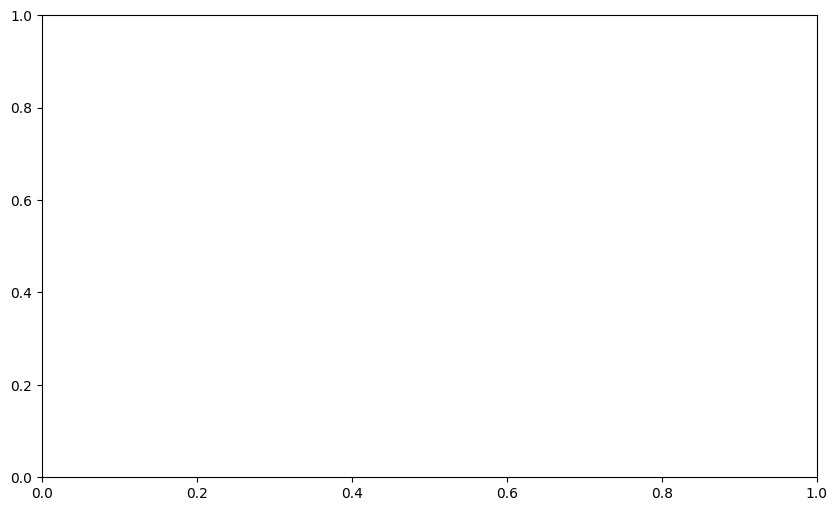

In [ ]:
# Plot the provider stats as a bar chart. Each provider should have a single bar that consists of 5 different colored
# segments.
plt.rcParams["figure.figsize"] = (10,6)
provider_labels = list(provider_stats.keys())
provider_values = np.array(
    [[v["uncomplained_objects"], v["appearance_complaint_objects"], v["collision_complaint_objects"], v["multiple_complaint_objects"], v["other_complaint_objects"]]
     for v in provider_stats.values()]
)
provider_values = provider_values.T
provider_values = provider_values / provider_values.sum(axis=0) * 100
provider_values = provider_values.astype(int)
provider_values = provider_values.T
provider_values = np.vstack((provider_values, provider_values.sum(axis=0)))
provider_labels.append("Total")
provider_values = np.vstack((provider_values, provider_values.sum(axis=0)))
provider_values = provider_values.astype(int)

indexes = np.arange(len(provider_labels))
width = 0.15
bar1 = plt.bar(indexes, provider_values[:, 0], width, label="Complained")
bar2 = plt.bar(indexes + width, provider_values[:, 1], width, label="Uncomplained")
bar3 = plt.bar(indexes + 2 * width, provider_values[:, 2], width, label="Appearance")
bar4 = plt.bar(indexes + 3 * width, provider_values[:, 3], width, label="Collision")
bar5 = plt.bar(indexes + 4 * width, provider_values[:, 4], width, label="Multiple")
bar6 = plt.bar(indexes + 5 * width, provider_values[:, 5], width, label="Other")
plt.xticks(indexes + 2.5 * width, provider_labels, rotation=45)
plt.legend()
plt.title("Complaints by Provider")
plt.xlabel("Provider")
plt.ylabel("Percentage")
plt.tight_layout()
plt.show()